# 1.0 Import

In [1]:
#Load and edit dataframe
import pandas as pd
import warnings 
warnings.filterwarnings( 'ignore' ) 

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Select Variables
from sklearn.feature_selection import SelectKBest

# ML - Algoritms
from sklearn.model_selection   import GridSearchCV
from sklearn.neural_network    import MLPRegressor
from sklearn.preprocessing     import MinMaxScaler
from sklearn                   import datasets, linear_model

# Metric
from sklearn.metrics           import mean_squared_error, r2_score


## Load DataSet

In [2]:
df = pd.read_csv('../data/all_b3_bovespa.csv')

In [3]:
df1 = df.copy()

# Data Analysis


In [4]:
print(f'nº of columns: {df1.shape[0]}, nº of rows:{df1.shape[1]}')

nº of columns: 733407, nº of rows:10


# Select only one share to predict

In [5]:
# Filter share_data
df_itau = df1[df1['sigla_acao']=='ITUB4']
print(f'nº of rows: {df_itau.shape[0]}, nº of columns:{df_itau.shape[1]}')

nº of rows: 1730, nº of columns:10


# Data transformation

In [6]:
df_itau['data_pregao'] = pd.to_datetime(df_itau['data_pregao'], format='%Y-%m-%d')

# Feature Engirennering

In [7]:
# Average moving 
df_itau['avg_5d'] = df_itau['preco_fechamento'].rolling(5).mean()
#.rolling method is used to provide rolling window calculations and math operations.
df_itau['avg_21d'] = df_itau['preco_fechamento'].rolling(21).mean()

In [9]:
df_itau.tail()

,data_pregao,codbdi,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios,avg_5d,avg_21d
686114,2021-12-23,2.0,ITUB4,ITAUUNIBANCO,21.33,21.57,21.17,21.34,22377000,4,21.258,22.184762
686115,2021-12-27,2.0,ITUB4,ITAUUNIBANCO,21.48,21.70,21.31,21.56,14025800,3,21.280,22.104286
686116,2021-12-28,2.0,ITUB4,ITAUUNIBANCO,21.63,21.70,21.40,21.48,15294200,3,21.352,22.040952
686117,2021-12-29,2.0,ITUB4,ITAUUNIBANCO,21.53,21.58,21.23,21.30,12856100,2,21.382,21.976190
686118,2021-12-30,2.0,ITUB4,ITAUUNIBANCO,21.44,21.44,20.95,20.95,39997300,8,21.326,21.908095


In [10]:
# Pushing action values to validate prediction 
df_itau['preco_fechamento'] = df_itau['preco_fechamento'].shift(-1)
"""The .shift() method is used to shift the DataFrame index by a 
specified number of periods with an optional time frequency."""

'The .shift() method is used to shift the DataFrame index by a \nspecified number of periods with an optional time frequency.'

## Clean DataFrame dropna()

In [11]:
# DropNAN
df_itau.dropna(inplace=True)

In [12]:
df_itau = df_itau.drop(['codbdi'], axis=1)

In [13]:
df_itau.head()

,data_pregao,sigla_acao,nome_acao,preco_abertura,preco_maximo,preco_minimo,preco_fechamento,qtd_negocios,volume_negocios,avg_5d,avg_21d
6409,2015-01-30,ITUB4,ITAUUNIBANCO,32.72,33.08,32.47,33.32,17879700,5,33.720,34.138095
6725,2015-02-02,ITUB4,ITAUUNIBANCO,33.22,33.38,32.65,34.25,11582800,3,33.498,34.113810
7046,2015-02-03,ITUB4,ITAUUNIBANCO,34.49,34.67,34.08,35.51,18005600,6,33.488,34.125714
7360,2015-02-04,ITUB4,ITAUUNIBANCO,34.22,35.72,34.00,35.21,24051000,8,33.870,34.171429
7653,2015-02-05,ITUB4,ITAUUNIBANCO,35.35,35.78,35.00,35.13,18834700,6,34.238,34.143333


Assumption:
At this point, I cleaned the dataframe by removing all null values, with that we lost 20 lines of the dataframe which does not offer any significant loss of the set.

In [14]:
df_itau.info()
# After cleaned

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1709 entries, 6409 to 686117
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data_pregao       1709 non-null   datetime64[ns]
 1   sigla_acao        1709 non-null   object        
 2   nome_acao         1709 non-null   object        
 3   preco_abertura    1709 non-null   float64       
 4   preco_maximo      1709 non-null   float64       
 5   preco_minimo      1709 non-null   float64       
 6   preco_fechamento  1709 non-null   float64       
 7   qtd_negocios      1709 non-null   int64         
 8   volume_negocios   1709 non-null   int64         
 9   avg_5d            1709 non-null   float64       
 10  avg_21d           1709 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 160.2+ KB


In [15]:
qntt_rows = len(df_itau)
r_train = qntt_rows -513 # 70% to train
r_test = qntt_rows -20 # 29% to test

r_validation = r_train - r_test  # 1% to validation

info = (
    f'Train = 0:{r_train} | '
    f'Test = {r_train}:{r_test} | '
    f'Validation = {r_test}:{qntt_rows}')
info

'Train = 0:1196 | Test = 1196:1689 | Validation = 1689:1709'

In [16]:
# Re-index to DataFrame
df_itau = df_itau.reset_index(drop=True)

# Feature Selection

In [17]:
feature = df_itau.drop(['data_pregao', 'sigla_acao', 'nome_acao','preco_fechamento'], axis=1)
target = df_itau['preco_fechamento']

In [18]:
display(feature.head())

,preco_abertura,preco_maximo,preco_minimo,qtd_negocios,volume_negocios,avg_5d,avg_21d
0,32.72,33.08,32.47,17879700,5,33.720,34.138095
1,33.22,33.38,32.65,11582800,3,33.498,34.113810
2,34.49,34.67,34.08,18005600,6,33.488,34.125714
3,34.22,35.72,34.00,24051000,8,33.870,34.171429
4,35.35,35.78,35.00,18834700,6,34.238,34.143333


In [19]:
#Escolhendo as melhores features com Kbest
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

features_list = ('preco_abertura', 'preco_maximo',
                 'preco_minimo', 'qtd_negocios',
                 'volume_negocios', 'avg_5d', 'avg_21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(feature, target)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Best features:")
print (k_best_features_final)


Best features:
{'qtd_negocios': 67.87763690386434, 'preco_minimo': 66.00545008164, 'preco_maximo': 56.5992793322479, 'avg_21d': 46.75419709805945, 'volume_negocios': 1.5377905100087315, 'avg_5d': 1.0676218044195167}


In [20]:
# result feature selection
features = feature.drop(['preco_abertura'], axis=1)

In [21]:
print('Features:')
print(features.head(5))

print('===============')

print('Target:')
print(target.head(5))

Features:
   preco_maximo  preco_minimo  qtd_negocios  volume_negocios  avg_5d  \
0         33.08         32.47      17879700                5  33.720   
1         33.38         32.65      11582800                3  33.498   
2         34.67         34.08      18005600                6  33.488   
3         35.72         34.00      24051000                8  33.870   
4         35.78         35.00      18834700                6  34.238   

     avg_21d  
0  34.138095  
1  34.113810  
2  34.125714  
3  34.171429  
4  34.143333  
Target:
0    33.32
1    34.25
2    35.51
3    35.21
4    35.13
Name: preco_fechamento, dtype: float64


In [22]:
# Reescale to features
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print('Features: ', features_scale.shape)
print(features_scale)

Features:  (1709, 6)
[[0.367468   0.38239804 0.14431072 0.15151515 0.39741055 0.40628679]
 [0.37683422 0.38791782 0.08683234 0.09090909 0.39033102 0.40547549]
 [0.41710896 0.4317694  0.14545994 0.18181818 0.39001212 0.40587318]
 ...
 [0.01217608 0.04017173 0.10913215 0.09090909 0.00070158 0.00427921]
 [0.01217608 0.04293162 0.12071016 0.09090909 0.00299764 0.00216347]
 [0.0084296  0.03771849 0.09845508 0.06060606 0.00395433 0.        ]]


# Data Train and Test

In [23]:
X_train = features_scale[:r_train]
X_test = features_scale[r_train:r_test]

y_train = target[:r_train]
y_test = target[r_train:r_test]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))



1196 1196
493 493


# Machine Learn  - Model's

## Linear-Regressor

In [24]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
pred= lr.predict(X_test)
cd =r2_score(y_test, pred)

f'Determination coefficient:{cd * 100:.2f}'

'Determination coefficient:85.93'

**_"The coefficient of determination, also called R², is a measure of the fit of a generalized linear statistical model, such as simple or multiple linear regression, to the observed values of a random variable. The R² varies between 0 and 1, sometimes being expressed in percentage terms. In this case, it expresses the amount of data variance that is explained by the linear model. Thus, the higher the R², the more explanatory the linear model is, that is, the better it fits the sample. For example, a R² = 0.8234 means that the linear model explains 82.34% of the variance of the dependent variable from the regressors (independent variables) included in that linear model."_**

## MLP Regressor

In [25]:
#rede neural
rn = MLPRegressor(max_iter=2000)

rn.fit(X_train, y_train)
pred= rn.predict(X_test)

cd = rn.score(X_test, y_test)

f'Determination coefficient:{cd * 100:.2f}'

'Determination coefficient:87.24'

In [26]:
### HyperParameters Fine-Tunning

In [27]:
import warnings 
warnings.filterwarnings( 'ignore' ) 

rn_ft = MLPRegressor()

parameter_space = {
        'hidden_layer_sizes': [(i,) for i in list(range(1, 21))],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam', 'lbfgs'], 
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
    }

search = GridSearchCV(rn, parameter_space, n_jobs=-1, cv=5)


search.fit(X_train,y_train)
clf = search.best_estimator_
pred= search.predict(X_test)

cd = search.score(X_test, y_test)

f'Determination coefficient:{cd * 100:.2f}'

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklea

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklea

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklea

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: Convergen

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  se

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: Convergen

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: Convergen

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: Convergen

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  se

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: Convergen

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  se

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  se

/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/bruno/.local/lib/python3.8/site-packages/sklea

'Determination coefficient:83.69'

In [28]:
# Predict
predict = features_scale[r_test:qntt_rows]

data_pregao_full = df_itau['data_pregao']
data_pregao = data_pregao_full[r_test:qntt_rows]

res_full = df_itau['preco_fechamento']
res = res_full[r_test:qntt_rows]

pred=rn.predict(predict)

df_pred = pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'predict':pred})

df_pred['real'] = df_pred['real'].shift(+1)  #→ return to original date

df_pred.set_index('data_pregao', inplace=True)

print(df_pred)

              real    predict
data_pregao                  
2021-12-01     NaN  22.744134
2021-12-02   23.06  22.867023
2021-12-03   22.98  23.235220
2021-12-06   23.25  23.396587
2021-12-07   22.96  23.306066
2021-12-08   22.74  22.958341
2021-12-09   22.13  22.609410
2021-12-10   22.16  22.421140
2021-12-13   21.57  22.140992
2021-12-14   21.78  22.088886
2021-12-15   21.71  21.849584
2021-12-16   21.93  21.934302
2021-12-17   21.45  21.725784
2021-12-20   21.12  21.410508
2021-12-21   21.15  21.381308
2021-12-22   21.23  20.812963
2021-12-23   21.34  21.416251
2021-12-27   21.56  20.802396
2021-12-28   21.48  20.931866
2021-12-29   21.30  20.467091


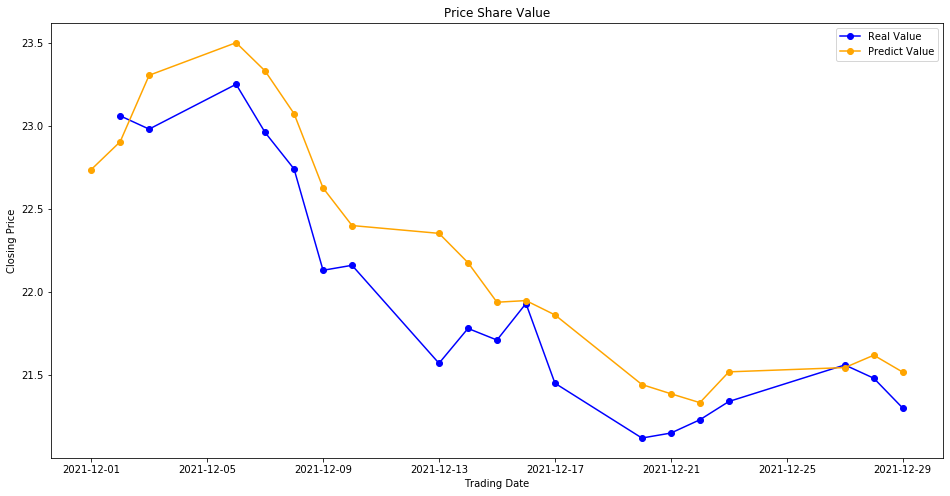

In [49]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_pred['real'], label='Real Value', color='blue', marker='o');
plt.plot(df_pred['predict'], label='Predict Value', color='orange', marker='o');
plt.xlabel('Trading Date');
plt.ylabel('Closing Price');
leg = plt.legend()


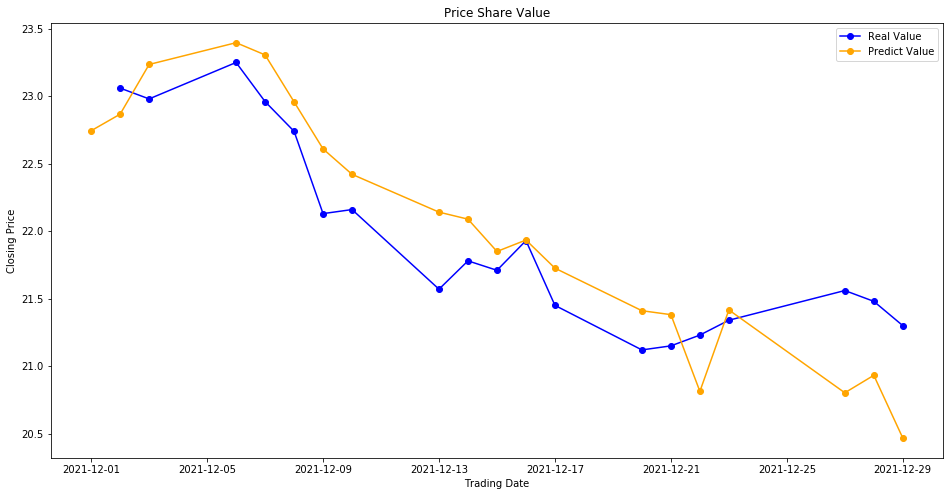

In [29]:
plt.figure(figsize=(16,8))
plt.title('Price Share Value')
plt.plot(df_pred['real'], label='Real Value', color='blue', marker='o');
plt.plot(df_pred['predict'], label='Predict Value', color='orange', marker='o');
plt.xlabel('Trading Date');
plt.ylabel('Closing Price');
leg = plt.legend()


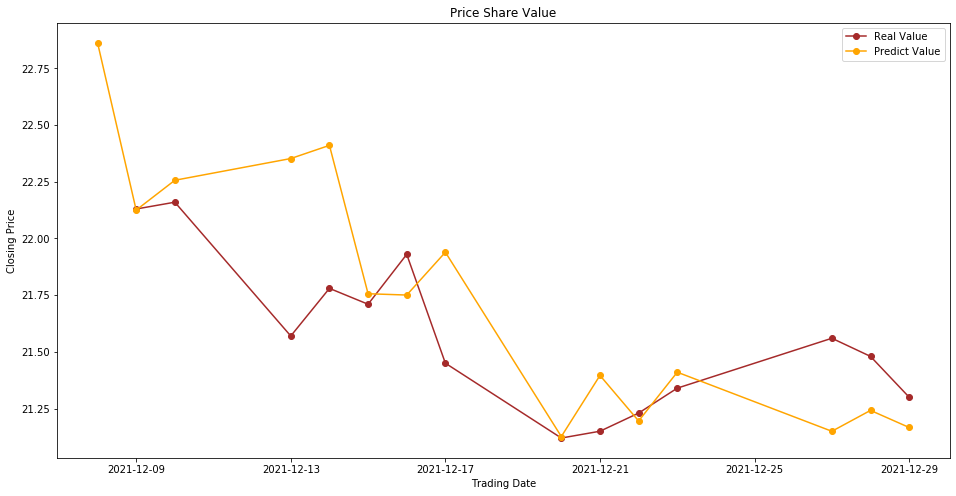

In [99]:
#plt.figure(figsize=(16,8))
#plt.title('Price Share Value')
#plt.plot(df_pred['real'], label='Real Value', color='brown', marker='o');
#plt.plot(df_pred['predict'], label='Predict Value', color='orange', marker='o');
#plt.xlabel('Trading Date');
#plt.ylabel('Closing Price');
#leg = plt.legend()
